In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision.utils import save_image
import os

In [2]:
# download data
url = 'https://gitlab.com/yuxuan.chen/'\
    'deep-learning-examples/-/raw/master/'\
    '02-Intermediate/mnist.npz'
!wget -nc $url

# load data
with np.load('mnist.npz') as fh:
    data_x = fh['train'].astype(np.float32)
    data_y = fh['train_labels'].astype(np.uint8)

data_x = np.transpose(data_x)
data_y = np.squeeze(np.transpose(data_y))
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# normalization from [0, 255] to [-1, 1]
data_x = (data_x - 127.5) / 127.5

File ‘mnist.npz’ already there; not retrieving.

(60000, 784) float32
(60000,) uint8


In [3]:
# hyper-parameters
input_size = 784
hidden_size = 256
latent_size = 32
num_classes = 10
num_epochs = 200
batch_size = 200
learning_rate = 0.0002
weight_decay = 0

# set device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

# create dataloader
data_loader = tf.data.Dataset.from_tensor_slices((data_x, data_y))
data_loader = data_loader.shuffle(
    buffer_size=data_x.shape[0], 
    reshuffle_each_iteration=True
).batch(batch_size)

In [4]:
class Discriminator(keras.Model):
    def __init__(self, input_size, hidden_size, 
                 conditional=False, num_classes=10):
        super(Discriminator, self).__init__()
        self.conditional = conditional
        self.num_classes = num_classes if conditional else 0

        self.fc1 = Sequential([Dense(hidden_size), 
                               LeakyReLU(0.1)])        
        self.fc2 = Sequential([Dense(hidden_size), 
                               LeakyReLU(0.1)])        
        self.fc3 = Sequential([Dense(hidden_size // 2), 
                               LeakyReLU(0.1)])
        self.fc4 = Dense(1, activation=tf.nn.sigmoid)
    
    def call(self, x, y=None):
        if self.conditional:
            y = tf.one_hot(indices=y, depth=num_classes)
            x = tf.concat([x, y], axis=-1)
        out = self.fc4(self.fc3(self.fc2(self.fc1(x))))
        return out



class Generator(keras.Model):
    def __init__(self, output_size, hidden_size, latent_size, 
                 conditional=False, num_classes=0):
        super(Generator, self).__init__()
        self.conditional = conditional
        self.num_classes = num_classes if conditional else 0

        self.fc1 = Sequential([Dense(hidden_size), 
                               LeakyReLU(0.1)])
        self.fc2 = Sequential([Dense(hidden_size), 
                               LeakyReLU(0.1)])
        self.fc3 = Sequential([Dense(hidden_size * 2), 
                               LeakyReLU(0.1)])
        self.fc4 = Dense(output_size, activation='tanh')
    
    def call(self, z, y=None):
        if self.conditional:
            y = tf.one_hot(indices=y, depth=self.num_classes)
            z = tf.concat([z, y], axis=-1)
        out = self.fc4(self.fc3(self.fc2(self.fc1(z))))
        return out

## Vanilla GAN

In [5]:
# set model and optimizer
D = Discriminator(input_size, hidden_size)
G = Generator(input_size, hidden_size, latent_size)

criterion = BinaryCrossentropy(name='binary_crossentropy')
d_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
g_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

Epoch [5/200], d_loss: 15.4249, g_loss: 0.0000


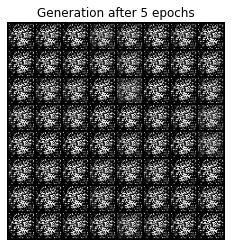

Epoch [10/200], d_loss: 15.4249, g_loss: 0.0000


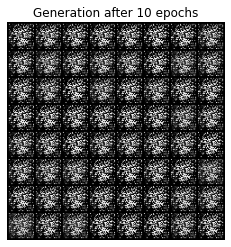

In [6]:
# start training
for epoch in range(num_epochs):
    for images, _ in data_loader:
        real_labels = tf.ones([batch_size, 1])
        fake_labels = tf.zeros([batch_size, 1])

        # ===== TRAIN THE DISCRIMINATOR =====
        z = np.random.randn(batch_size, latent_size)
        with tf.GradientTape() as tape:
            # compute loss using real images and real labels
            pred_real = D(images, training=True)
            d_loss_real = criterion(pred_real, real_labels)

            # compute loss using fake images and fake labels
            fake_images = G(z, training=False)
            pred_fake = D(fake_images, training=True)
            d_loss_fake = criterion(pred_fake, fake_labels)

            # add l2 loss
            l2_loss = weight_decay * tf.add_n(
                [tf.nn.l2_loss(v) for v in D.trainable_variables])
            d_loss = d_loss_real + d_loss_fake + l2_loss
        
        # b-p
        grad = tape.gradient(d_loss, D.trainable_variables)
        d_optimizer.apply_gradients(
            zip(grad, D.trainable_variables))
        
        # ===== TRAIN THE GENERATOR =====
        with tf.GradientTape() as tape:
            # compute loss using fake images and real labels
            z = np.random.randn(batch_size, latent_size)
            fake_images = G(z, training=True)
            pred_fake = D(fake_images, training=True)
            g_loss = criterion(pred_fake, real_labels)

            # add l2 loss
            l2_loss = weight_decay * tf.add_n(
                [tf.nn.l2_loss(v) for v in G.trainable_variables])
            g_loss += l2_loss
        
        # b-p
        grad = tape.gradient(g_loss, G.trainable_variables)
        g_optimizer.apply_gradients(
            zip(grad, G.trainable_variables))

    # print results for the last batch after every some epochs
    if (epoch + 1) % 5 == 0:
        print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(
                epoch + 1, num_epochs, d_loss, g_loss))

        # save image
        fake_images = torch.from_numpy(((fake_images.numpy() + 1) / 2))
        fake_images = fake_images[:64].reshape(-1, 1, 28, 28)
        save_image(fake_images, 'fake-images.png', nrow=8)
        
        # plot
        img = mpimg.imread('fake-images.png')
        plt.axis('off')
        plt.imshow(img)
        plt.title('Generation after {} epochs'.format(epoch + 1))
        plt.show()